# What are users struggling the most with?

- Only 0.88% of cells have errors.
- 14.92% of notebooks have at least one error.
- Errors are less frequent in notebooks using machine learning frameworks. We are 95% confident that the average number of errors in notebooks using one of the three machine learning frameworks is between 0.09 and 0.05 lower than the average number of errors in notebooks not using machine learning.
----------

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import scipy.stats as st
import math
import matplotlib.pyplot as plt

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load()
notebooks = notebooks[notebooks.lang_name == 'python']
cells = cells[cells.file.isin(notebooks.file)]
repos = repos[repos.repo_id.isin(notebooks.repo_id)]
owner = owners[owners.owner_id.isin(repos.owner_id)]
readmes = readmes[readmes.readme_id.isin(repos.readme_id)]

# Looking at Errors

In [3]:
percent_error = 100 * sum(cells.num_error > 0) / len(cells)
print("Only {0}% of cells have errors.".format(round(percent_error, 2)))

Only 0.88% of cells have errors.


In [4]:
file_errors = cells.groupby('file')['num_error'].sum().reset_index()
percent_nb_error = 100 * sum(file_errors.num_error > 0) / len(file_errors)
none = sum(file_errors.num_error == 0)
at_least_1 = sum(file_errors.num_error > 0)
at_least_5 = sum(file_errors.num_error >= 5)

print("{0}% of notebooks have at least one error.".format(round(percent_nb_error, 2)))
print("\n{0} notebooks have no errors.".format(round(none, 2)))
print("{0} notebooks have at least one error.".format(round(at_least_1, 2)))
print("{0} notebooks have at least five errors.".format(round(at_least_5, 2)))

14.92% of notebooks have at least one error.

15106 notebooks have no errors.
2649 notebooks have at least one error.
76 notebooks have at least five errors.


In [5]:
error_cells = cells[cells.num_error > 0]
all_errors = ','.join([','.join([e for e in error]) for error in error_cells.error_names]).split(',')
error_counts = pd.Series(all_errors).value_counts().reset_index().rename(columns = {'index':'error', 0:'count'})

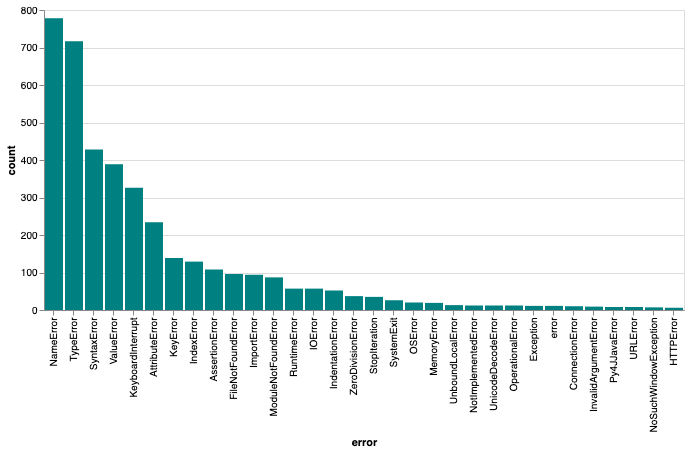

In [6]:
alt.Chart(error_counts[error_counts['count'] > 5]).mark_bar(color = 'teal').encode(
    alt.X('error', sort = alt.EncodingSortField(field="count", op="sum",order="descending")),
    alt.Y('count')
)

# Are errors more or less likely to occur in notebooks using machine learning frameworks?

In [7]:
cells['sklearn'] = [sum([e[0].startswith('sklearn') for e in errors]) > 1 for errors in cells['imports']]
cells['tensorflow'] = [sum([e[0].startswith('tensorflow') for e in errors]) > 1 for errors in cells['imports']]
cells['keras'] = [sum([e[0].startswith('keras') for e in errors]) > 1 for errors in cells['imports']]

In [8]:
def at_least1(list_of_bool):
    return sum(list_of_bool) > 0

cells = cells.drop(['sklearn','tensorflow','keras'], axis = 1).merge(cells.groupby('file')[
    ['sklearn','tensorflow','keras']
].aggregate(at_least1).reset_index(), on = 'file')

$H_0$: $µ_{ml}$ = $µ_{not ml}$

$H_0$: $µ_{ml}$ ≠ $µ_{not ml}$

Where $µ_{ml}$ is the average number of errors in a notebook using at least one of the tree machine learning frameworks, $µ_{not ml}$ is the average number of errors in a notebook *not* using any of the tree machine learning frameworks.

In [9]:
file_errors_ml = cells.groupby('file')[
    ['sklearn','tensorflow','keras']
].aggregate(at_least1).reset_index().merge(file_errors, on = 'file')

ml_files = file_errors_ml[
    np.logical_or(file_errors_ml['keras'], np.logical_or(file_errors_ml['sklearn'], file_errors_ml['tensorflow']))
]

non_ml_files = file_errors_ml[
    ~np.logical_or(file_errors_ml['keras'], np.logical_or(file_errors_ml['sklearn'], file_errors_ml['tensorflow']))
]

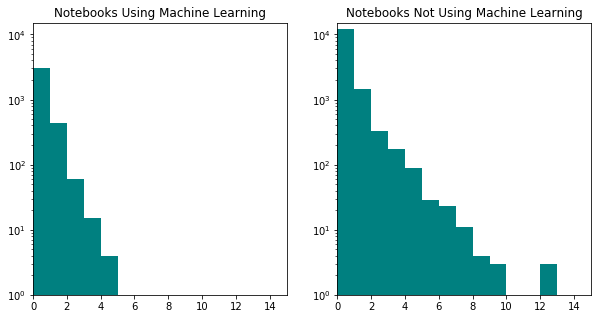

In [10]:
fig = plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title('Notebooks Using Machine Learning')
plt.yscale('log')
plt.ylim(1, 15000)
plt.xlim(0, 15)
plt.hist(ml_files.num_error, bins = range(15), color = 'teal')

plt.subplot(1,2,2)
plt.title('Notebooks Not Using Machine Learning')
plt.yscale('log')
plt.ylim(1, 15000)
plt.xlim(0, 15)
plt.hist(non_ml_files.num_error, bins = range(15), color = 'teal')

plt.show()

Both groups of notebooks number of errors concentrated at 0, which makes sense seeing as only 14.92% of notebooks have errors. There are many more notebooks not using machine learning than there are using maching learning frameworks. Both distributions are skewed right. The number of errors for notebooks not using machine learning go far higher than that for notebooks using machine learning.

In [11]:
n_ml = len(ml_files)
xbar_ml = pd.Series(ml_files.num_error).mean()
s2_ml = pd.Series(ml_files.num_error).var()

n_notml = len(non_ml_files)
xbar_notml = pd.Series(non_ml_files.num_error).mean()
s2_notml = pd.Series(non_ml_files.num_error).var()

df = n_ml + n_notml - 2

t = (xbar_ml - xbar_notml) / math.sqrt(s2_ml/n_ml + s2_notml/n_notml)
p_value = 2*st.t.cdf(t, df)

print("T-statistic:", round(t,2))
print("P-value:", round(p_value,2))

T-statistic: -7.05
P-value: 0.0


At any reasonable significance level, the p-value of 0.0 provides very strong evidence to reject the null hypothesis and conclude that the mean number of errors is different between notebooks using at least one of the three main machine learning frameworks (tensorflow, keras, sklearn) and notebooks using none.

In [13]:
lower = (xbar_ml - xbar_notml) -  st.t.ppf(0.975, df) * math.sqrt(s2_ml/n_ml + s2_notml/n_notml)
upper = (xbar_ml - xbar_notml) + st.t.ppf(0.975, df) * math.sqrt(s2_ml/n_ml + s2_notml/n_notml)
print("""We are 95% confident that the average number of errors in notebooks using one of the \
three machine learning frameworks is between {0} and {1} lower than the average number of errors \
in notebooks not using machine learning.""".format(
    round(-1*upper, 2),
    round(-1*lower, 2)
))

We are 95% confident that the average number of errors in notebooks using one of the three machine learning frameworks is between 0.05 and 0.09 lower than the average number of errors in notebooks not using machine learning.


Errors are less likely in notebooks using machine learning frameworks. This may be because the owners of these notebooks are more experienced than users who do not use machine learning. It's also possible that notebooks using machine learning frameworks are written as presentation quality, while other notebooks could be more for personal exploration.

<center> <a href = 7_Time.ipynb>Time Spent &lt;</a> | <a href = 9_APIs.ipynb>&gt; API Design</a> <center>